# Assignment 4 - Neural Networks

## *ERIC RIOS SODERMAN*
Netid: ejr41

*Names of students you worked with on this assignment*: **Wafiakmal Mitah, Songyoung Oh**

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [60 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [1]:
# Optional for clear plotting on Macs
# %config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"


In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

# -----------------------------------------------------------------------------
# Create the data
# -----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    """Data generation function from Professor to create dataset"""
    n_samples = int(n / 4)
    shift = 0.5
    c1a = np.random.randn(n_samples, 2) * noise + [-shift, shift]
    c1b = np.random.randn(n_samples, 2) * noise + [shift, -shift]
    c0a = np.random.randn(n_samples, 2) * noise + [shift, shift]
    c0b = np.random.randn(n_samples, 2) * noise + [-shift, -shift]
    X = np.concatenate((c1a, c1b, c0a, c0b), axis=0)
    y = np.concatenate((np.ones(2 * n_samples), np.zeros(2 * n_samples)))

    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X) > cutoff
    for index, value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand() * 2.5 - 1.25
    return (X, y)


# Training datasets
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)

# Validation and test data
X_val, y_val = make_data_normal_checkerboard(500, noise=noise)
X_test, y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)


To help get you started we should always begin by visualizing our training data, here's some code that does that:

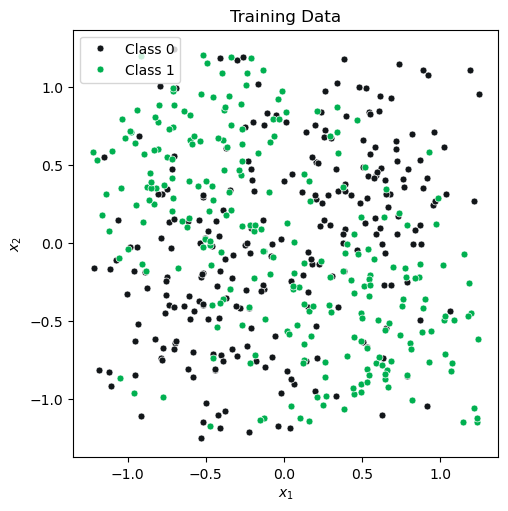

In [3]:
import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax, X, y, title, limits, legend=True):
    """Plot the data colored by labels with title"""
    # Select the colors to use in the plots
    color0 = "#121619"  # Dark grey
    color1 = "#00B050"  # Green
    color_boundary = "#858585"

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if legend:
        ax.legend(loc="upper left")
    ax.set_aspect("equal")


fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, "Training Data", limits, legend=True)


The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

Answer
---

## 1a

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

In [4]:
# Function to plot decision boundary


def plot_decision_boundary(ax, model, limits):
    """Plot the decision boundary of a model"""
    color_boundary = "#858585"

    # Create a grid of points
    x1 = np.linspace(limits[0], limits[1], 500)
    x2 = np.linspace(limits[2], limits[3], 500)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.c_[xx1.ravel(), xx2.ravel()]

    # Get the decision boundary
    yhat = model.predict(X)
    zz = yhat.reshape(xx1.shape)

    # Plot the decision boundary
    ax.imshow(
        np.flipud(zz),
        extent=[limits[0], limits[1], limits[2], limits[3]],
        cmap="RdBu",
        alpha=0.6,
    )
    ax.contour(xx1, xx2, zz, colors=["#fcff03", "#fcff03"], linewidths=1)


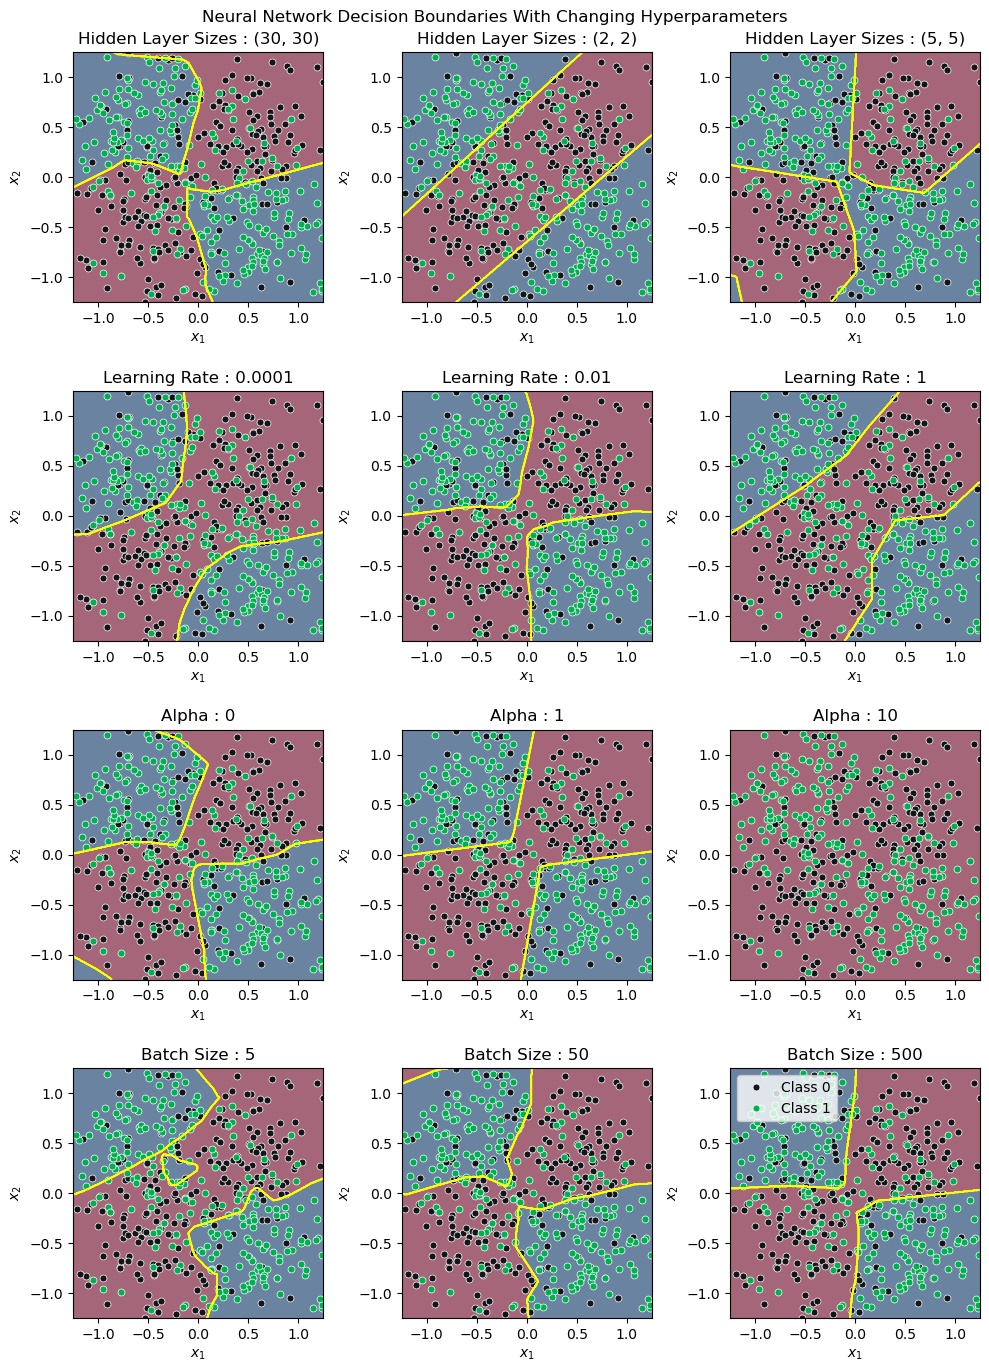

In [5]:
from sklearn.neural_network import MLPClassifier

configurations = {
    "hidden_layer_sizes": ([(30, 30), (2, 2), (5, 5)], "Hidden Layer Sizes"),
    "learning_rate_init": ([0.0001, 0.01, 1], "Learning Rate"),
    "alpha": ([0, 1, 10], "Alpha"),
    "batch_size": ([5, 50, 500], "Batch Size"),
}


fig = plt.figure(figsize=(10, 14), tight_layout=True, constrained_layout=True)


config_counter = 1

for configuration in configurations:

    for value in configurations[configuration][0]:

        ax = fig.add_subplot(4, 3, config_counter)

        model = MLPClassifier(
            learning_rate_init=0.03,
            hidden_layer_sizes=(30, 30),
            alpha=0,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=50,
            max_iter=500,
        )
        model.set_params(**{configuration: value})
        model.fit(X_train, y_train)

        title = configurations[configuration][1] + " : " + str(value)

        plot_data(ax, X_train, y_train, title, limits, legend=False)
        plot_decision_boundary(ax, model, limits)

        config_counter += 1

plt.legend(loc="upper left")
plt.suptitle("Neural Network Decision Boundaries With Changing Hyperparameters")
plt.show()


### Comments on decision boundaries

Here are some observations on the decision boundary plots:

> Having at least 5 nodes within hidden layers works well for this problem, with 2 nodes being too little, as it misclassifies much too many observations, and 30 looks optimal as well as it is less flexible than 5 nodes in its boundary.

> For learning rate, 0.0001 and 1 are inferior to 0.01, probably because it takes an appropriate amount of steps to converge, it neither goes on for too long or terminates too quickly, if one had to venture a guess. It performs well on segregating the classes. 

> When the regularization is too large (10), the observations are classified as one class. 1 and 0 are appropriate, but the boundary for an alpha of 0 is more flexible, allowing it to capture more observations.

> When the batch size is small (5), the boundary is quite elastic and flexible. When the batch size is 50, the boundary is more constrained than 5, but it appears that its form is introducing less variance than its smaller counterpart. As for the batch size of 500, it happens to actually be the most constrained, making the boundary lines look somewhat stiff or straight, less malleable unlike its counterparts.

> If one were to make a choice based on parameters, since the interplay of their combinations is not observed, some degree of hyperparameter tuning will be necessary.  



## 1b


**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

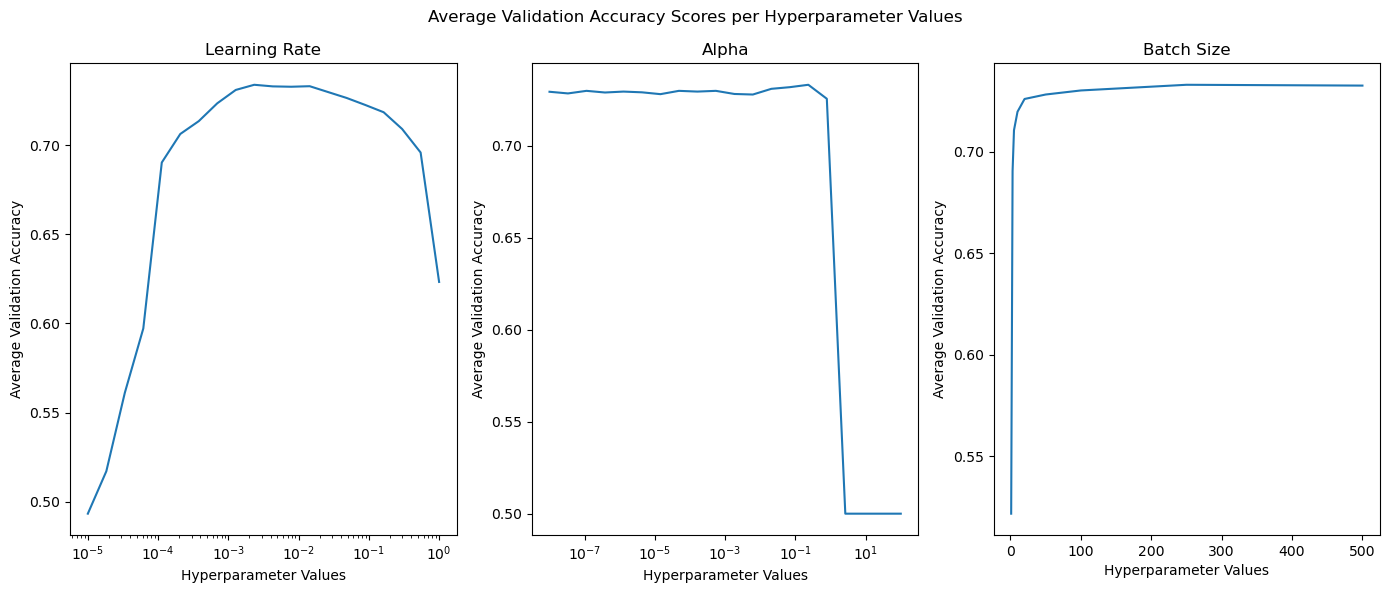

In [6]:
# The hyperparameters to test
learning_rates = np.logspace(-5, 0, 20).tolist()
alphas = np.logspace(-8, 2, 20).tolist()
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]

# Create a figure to plot the results
fig = plt.figure(figsize=(14, 6), tight_layout=True, constrained_layout=True)

# Preparing the configurations of the hyperparameters
configurations_b = {
    "learning_rate_init": (learning_rates, "Learning Rate"),
    "alpha": (alphas, "Alpha"),
    "batch_size": (batch_sizes, "Batch Size"),
}

# these iterations are to mitigate the noise from the results
n = 0

# Plotting the average accuracy scores by hyperparameter values
config_accuracy_scores = {"learning_rate_init": [], "alpha": [], "batch_size": []}
for count, configuration in enumerate(configurations_b, start=1):

    ax = fig.add_subplot(1, 3, count)
    accuracy_scores = []
    while n < 20:
        acc_scores = []
        for value in configurations_b[configuration][0]:
            model = MLPClassifier(
                learning_rate_init=0.03,
                hidden_layer_sizes=(30, 30),
                alpha=0,
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                batch_size=50,
                max_iter=500,
            )
            model.set_params(**{configuration: value})
            model.fit(X_train, y_train)
            acc_scores.append(model.score(X_val, y_val))
        accuracy_scores.append(acc_scores)
        n += 1

    n = 0  # resetting n for the next configuration
    # averaging the accuracy scores
    title = configurations[configuration][1]
    array_scores = np.array(accuracy_scores)
    mean_scores = np.mean(array_scores, axis=0)
    config_accuracy_scores[(configurations_b[configuration][1])] = mean_scores
    ax.plot(configurations_b[configuration][0], mean_scores)
    ax.set_title(title)
    ax.set_ylabel("Average Validation Accuracy")
    ax.set_xlabel("Hyperparameter Values")
    if configuration != "batch_size":
        ax.set_xscale("log")

plt.suptitle("Average Validation Accuracy Scores per Hyperparameter Values")
plt.show()


In [7]:
# Retrieving the best hyperparameters
best_hyperparameters = {"learning_rate_init": 0.0, "alpha": 0.0, "batch_size": 0}

for configuration in configurations_b:

    hyperparameter_values = np.array(configurations_b[configuration][0])
    scores = np.array(config_accuracy_scores[(configurations_b[configuration][1])])
    best_score = np.max(scores)
    best_hyperparameter = hyperparameter_values[np.argmax(scores)]
    best_hyperparameters[configuration] = best_hyperparameter

    # Printing the best hyperparameters
    if configuration == "batch_size":
        print(
            f"The optimal choice for {configurations_b[configuration][1]} is {best_hyperparameter}, which gave an accuracy of {best_score:.4f}."
        )
    else:
        print(
            f"The optimal choice for {configurations_b[configuration][1]} is {best_hyperparameter:.4f}, which gave an accuracy of {best_score:.4f}."
        )


The optimal choice for Learning Rate is 0.0023, which gave an accuracy of 0.7339.
The optimal choice for Alpha is 0.2336, which gave an accuracy of 0.7332.
The optimal choice for Batch Size is 250, which gave an accuracy of 0.7331.


For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.

> The optimal choice for the learning rate is 0.0023, which is near $10^-3$, and it yielded an accuracy score of 0.0.7339.

> The optimal choice for the alpha (regularization coefficient) is 0.2336, which is near $10^-1$, and it yielded an accuracy score of 0.7332.

> The optimal choice for the batch size is 250, and it yielded an accuracy score of 0.7331.

> These values were chosen for the hyperparameters because they yielded the best accuracy on the validation set. This validation set was used to inform the choices for hyperparameter tuning.

- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).

> Yes, running the algorithm 10 times was necessary to get less noisy estimates for the accuracy scores. 

- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

> Yes. Let's continue to the next steps. 

1C
---

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

In [8]:
# Vary the model architecture by changing the number of hidden layers and the number of neurons in each layer

# The hyperparameters to test
nodes_per_layer = [1, 2, 3, 4, 5, 10, 15, 25, 30]
layers_nums = [1, 2, 3, 4]


def node_layer_config(nodes_per_layer, layers_num):
    """Build the nodes-layers configuration to serve as a hyperparameter for the neural network model"""
    list_config = (np.ones((layers_num)) * nodes_per_layer).tolist()
    list_config = [int(i) for i in list_config]
    tuple_config = tuple(list_config)
    return tuple_config


In [9]:
# Recording the accuracy scores by the number of nodes and layers
node_layer_pairs = []
node_layer_pairs_scores = []

n = 0

while n < 20:
    score_list = []
    for nodes in nodes_per_layer:

        for layer in layers_nums:

            node_layer_val = node_layer_config(nodes, layer)

            model = MLPClassifier(
                learning_rate_init=best_hyperparameters["learning_rate_init"],
                hidden_layer_sizes=node_layer_val,
                alpha=best_hyperparameters["alpha"],
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                batch_size=best_hyperparameters["batch_size"],
                max_iter=500,
            )
            model.fit(X_train, y_train)
            score = round(model.score(X_val, y_val), 2)
            node_layer_pairs.append(node_layer_val)
            score_list.append(score)
    node_layer_pairs_scores.append(score_list)
    n += 1


In [10]:
# average the scores
node_layer_pairs_scores_avg = np.array(node_layer_pairs_scores).mean(axis=0)
node_layer_pairs_scores_avg

rounded_scores = [round(i, 2) for i in node_layer_pairs_scores_avg]
rounded_scores = np.array(rounded_scores)
rounded_scores = rounded_scores.reshape(9, 4)  # for the heatmap in next block


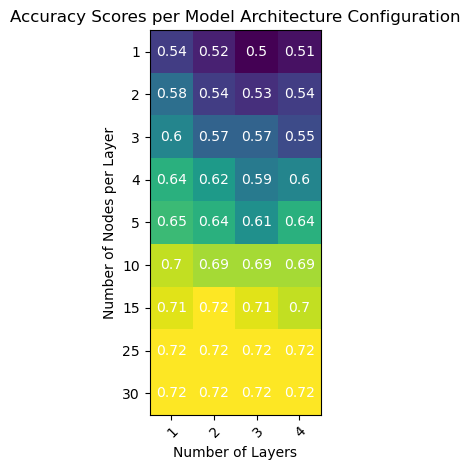

The objective choice for number of nodes per layer is (25,), which gave an accuracy of 0.7235.


In [30]:
# creating the heatmap
fig, ax = plt.subplots()
im = ax.imshow(rounded_scores)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(layers_nums)), labels=layers_nums)
ax.set_yticks(np.arange(len(nodes_per_layer)), labels=nodes_per_layer)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(nodes_per_layer)):
    for j in range(len(layers_nums)):
        text = ax.text(j, i, rounded_scores[i, j], ha="center", va="center", color="w")

ax.set_title("Accuracy Scores per Model Architecture Configuration")
ax.set_ylabel("Number of Nodes per Layer")
ax.set_xlabel("Number of Layers")
fig.tight_layout()
plt.show()

#  the model architecture with the highest accuracy
best_node_layer = node_layer_pairs[np.argmax(node_layer_pairs_scores_avg)]
print(
    f"The objective choice for number of nodes per layer is {best_node_layer}, which gave an accuracy of {np.max(node_layer_pairs_scores_avg):.4f}."
)


- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 

> Like before, to eliminate noisiness within the results, the models were run multiple times, and their accuracy scores were averaged. The optimal model with the highest accuracy but lowest number of model weights is the model with 1 hidden layer of 25 nodes. It was an amazing finding, realizing that the initialization of model weights could yield so many different results. I didn't set a random state on purpose just to appreciate the randomness of this process. 

- What do the results show? Which parameters did you select and why?

> The best average score was produced by the architecture with 25 nodes and 1 layer. Since the highest overall accuracy was within the range of 0.72, the choice remained the same. The model that still gave the highest accuracy was this one. This choice of (25,) will the definitive choice going forward. 

1d
---

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

In [62]:
# Train the best model on the training and validation data
best_model = MLPClassifier(
    learning_rate_init=best_hyperparameters["learning_rate_init"],
    hidden_layer_sizes=best_node_layer,
    alpha=best_hyperparameters["alpha"],
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    batch_size=best_hyperparameters["batch_size"],
    max_iter=500,
)
best_model.fit(X_train_plus_val, y_train_plus_val)

# Evaluate the best model on the test data
test_accuracy = best_model.score(X_test, y_test)
print(f"The test accuracy score for the best model is {test_accuracy:.4f}.")


The test accuracy score for the best model is 0.7300.


1e
---

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

In [63]:
import numpy as np

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier


# build a classifier
clf = MLPClassifier(
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    max_iter=500,
)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    "learning_rate_init": loguniform(1e-5, 1e0),
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500],
    "alpha": loguniform(1e-8, 1e2),
    "hidden_layer_sizes": node_layer_pairs,
}

# run randomized search
n_iter_search = 500
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    n_jobs=-1,
    cv=train_val_split,
)

start = time()
random_search.fit(X_train_plus_val, y_train_plus_val)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)


RandomizedSearchCV took 4016.32 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.748 (std: 0.000)
Parameters: {'alpha': 0.10067897700189372, 'batch_size': 50, 'hidden_layer_sizes': (15, 15, 15), 'learning_rate_init': 0.02774969380042282}

Model with rank: 2
Mean validation score: 0.746 (std: 0.000)
Parameters: {'alpha': 0.0029279139517833, 'batch_size': 10, 'hidden_layer_sizes': (15, 15), 'learning_rate_init': 0.001395851988241759}

Model with rank: 2
Mean validation score: 0.746 (std: 0.000)
Parameters: {'alpha': 0.01379822553677189, 'batch_size': 500, 'hidden_layer_sizes': (15,), 'learning_rate_init': 0.36634924161415977}



- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

In [64]:
rs_best_params = random_search.best_params_

print(
    "Manual Greedy Approach Learning Rate: ",
    best_hyperparameters["learning_rate_init"],
    "\n",
    "Random Search Best Learning Rate: ",
    rs_best_params["learning_rate_init"],
)

print(
    "Manual Greedy Approach Batch Size: ",
    best_hyperparameters["batch_size"],
    "\n",
    "Random Search Best Batch Size: ",
    rs_best_params["batch_size"],
)

print(
    "Manual Greedy Approach Alpha: ",
    best_hyperparameters["alpha"],
    "\n",
    "Random Search Best Alpha: ",
    rs_best_params["alpha"],
)

print(
    "Manual Greedy Approach Hidden Layer Sizes: ",
    best_node_layer,
    "\n",
    "Random Search Best Hidden Layer Sizes: ",
    rs_best_params["hidden_layer_sizes"],
)


Manual Greedy Approach Learning Rate:  0.002335721469090121 
 Random Search Best Learning Rate:  0.02774969380042282
Manual Greedy Approach Batch Size:  250 
 Random Search Best Batch Size:  50
Manual Greedy Approach Alpha:  0.23357214690901212 
 Random Search Best Alpha:  0.10067897700189372
Manual Greedy Approach Hidden Layer Sizes:  (25,) 
 Random Search Best Hidden Layer Sizes:  (15, 15, 15)


> These are the hyperparameters of the random search's best model versus the greedy and manual approach. The choices are somewhat similar and different. However, it is obvious that the random search was able to explore a larger space of hyperparameters. For example, the batch size was drastically different than the manual greedy approach.

In [65]:
random_search_best_score = random_search.best_estimator_.score(X_test, y_test)

print(f"The test accuracy score for my greedy search model is {test_accuracy:.4f}.")
print(
    f"The test accuracy score for the random search model is {random_search_best_score:.4f}."
)


The test accuracy score for my greedy search model is 0.7300.
The test accuracy score for the random search model is 0.7380.


> The random search model outperformed the greedy search model in terms of generalization performance, 0.7300 vs. 0.7440. In this particular instance, the performance improvement is meaningful. Although, the random search may also have results where it doesn't provide better hyperparameters than the greedy search.

- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 

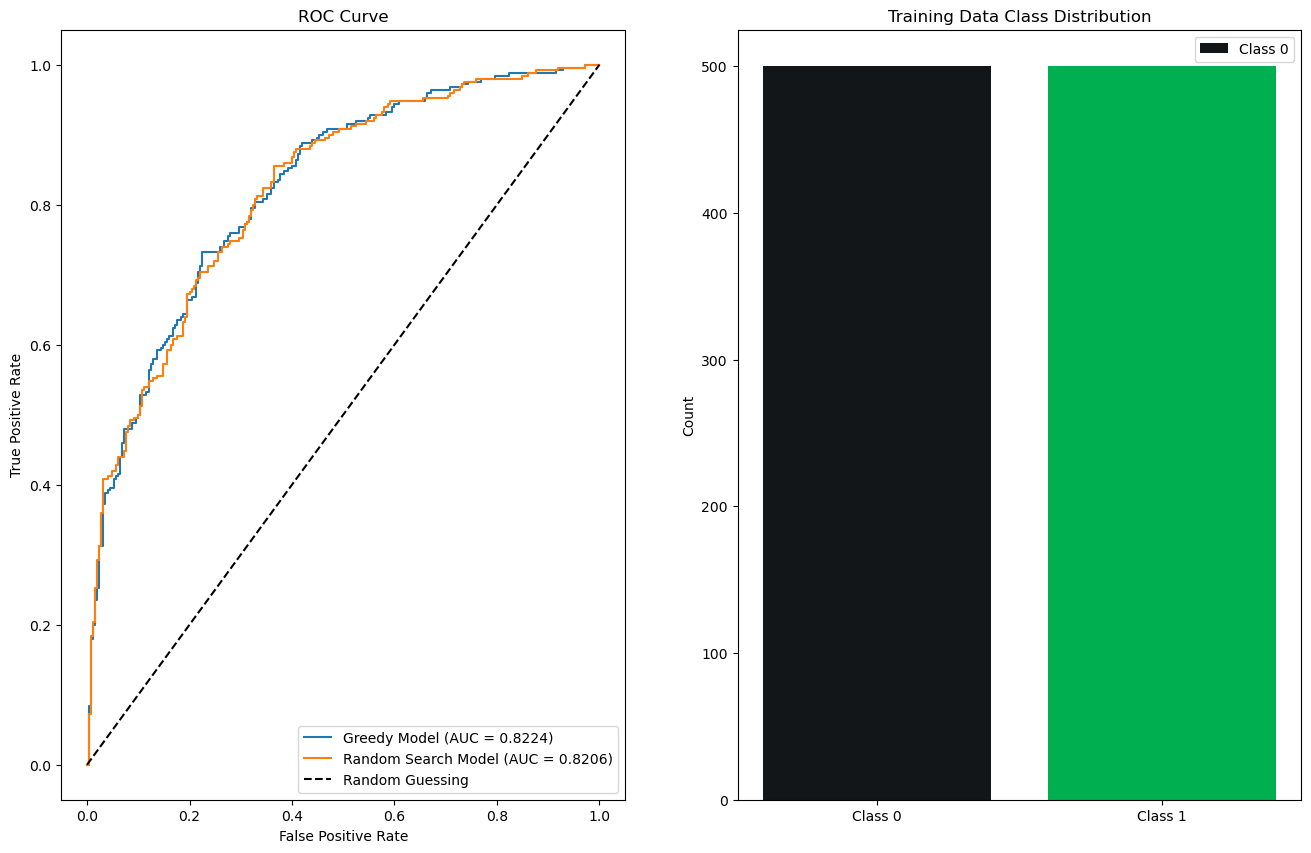

Class 0: 500 samples
Class 1: 500 samples


In [66]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

greedy_model_roc = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
random_search_model_roc = roc_curve(
    y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1]
)

greedy_model_roc_auc = auc(greedy_model_roc[0], greedy_model_roc[1])
random_search_model_roc_auc = auc(
    random_search_model_roc[0], random_search_model_roc[1]
)

# plot the roc curve for the greedy model, the random search model, and one that is just guessing
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(
    greedy_model_roc[0],
    greedy_model_roc[1],
    label=f"Greedy Model (AUC = {greedy_model_roc_auc:.4f})",
)
ax1.plot(
    random_search_model_roc[0],
    random_search_model_roc[1],
    label=f"Random Search Model (AUC = {random_search_model_roc_auc:.4f})",
)
ax1.plot([0, 1], [0, 1], "k--", label="Random Guessing")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curve")
ax1.legend(loc="lower right")


# Checking balance
#  Make a bar plot of the distribution of the classes in the training data
ax = fig.add_subplot(1, 2, 2)
ax.bar(
    [0, 1],
    [
        len(y_train_plus_val[y_train_plus_val == 0]),
        len(y_train_plus_val[y_train_plus_val == 1]),
    ],
    color=["#121619", "#00B050"],
)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Class 0", "Class 1"])
ax.set_ylabel("Count")
ax.set_title("Training Data Class Distribution")
ax.legend(["Class 0", "Class 1"])
plt.show()
print("Class 0: {} samples".format(len(y_train_plus_val[y_train_plus_val == 0])))
print("Class 1: {} samples".format(len(y_train_plus_val[y_train_plus_val == 1])))


- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary

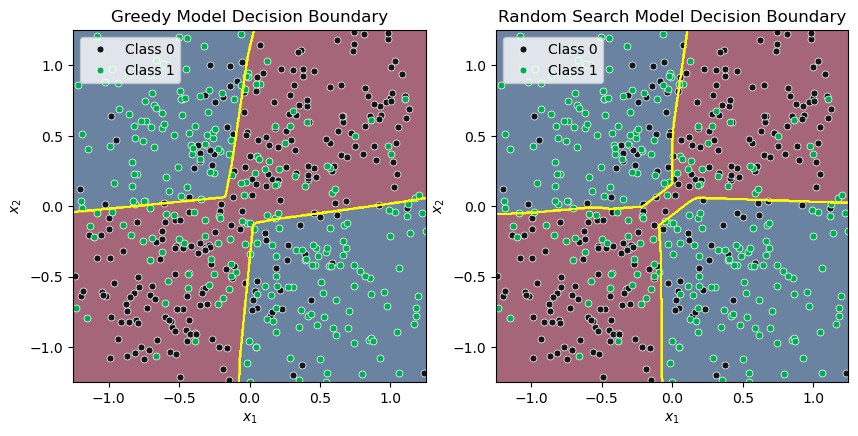

In [67]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1_title = "Greedy Model Decision Boundary"
ax2_title = "Random Search Model Decision Boundary"
plot_data(ax1, X_test, y_test, ax1_title, limits)
plot_decision_boundary(ax1, best_model, limits)
plot_data(ax2, X_test, y_test, ax2_title, limits)
plot_decision_boundary(ax2, random_search.best_estimator_, limits)
plt.show()



- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

> The results here are quite surprising. The random search model had a slightly better test accuracy, a slightly worse roc curve and a slightly worse AUC value than the greedy search counterpart. With classes, it is important to remember that class imbalances may affect performance; however, no imbalances were present in the training data. As for general test accuracy, the random search model had the better hyperparameters or maybe slightly better initialization weights (which then continously get updated with gradient descent). As to what is ocurring, the plausible theory is that the weights used inside that best random search instance were simply slightly better than the greedy model's weights. The greedy model, overall, is slightly better at predicting true positives and maximizing them while keeping the false positive rate lower. Due to needing more careful examination, the outputs of the key estimators were printed above. The greedy model exercised a slightly more aggressive learning rate than the random search model. This meant that the random search model took smaller steps during the gradient descent process, and optimized for potentially less relevant or impactful weights. It is a plausible theory that the small differences in the learning rate were a key difference. As for the other differences, they were related to hidden layer sizes and regularization coefficients, which were smaller for the random search model, while the batch size was identical. These would have to be the final differences that could account for the disparity in performance. In addition, the decision boundaries for the greedy search model were better representative in segregating the data than the random search model, which further adds evidence that the greedy search worked better for this problem. However, the boundary also suggests that the greedy model may be more flexible and produce more variance as a result. It is important to note that greedy search works well when there is enough domain knowledge to substantiate the choice of hyperparameters. If this domain knowledge is lacking, random search or grid search are the only other alternatives.

# 2

## [30 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [10 points of the 30]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: Due to the depth this question requires, some students may choose not to complete this section (in lieu of receiving the 10 points from this question). If you choose not to build your own neural network, or if your neural network is not functional prior to submission, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead.**

In [68]:
# neural network class skeleton code


class myNeuralNetwork(object):
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """

    def compute_loss(self, X, y):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        """

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss functionof the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        """

    def stochastic_gradient_descent_step(self):
        """stochastic_gradient_descent_step [OPTIONAL - you may also do this
        directly in backpropagate]
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.

        Input: none
        Output: none
        """

    def fit(self, X, y, max_epochs, learning_rate, get_validation_loss):
        """fit
        Input:
            X: A matrix of N samples of data [N x n_in]
            y: Target variable [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                             [optional output if get_validation_loss==True]
        """

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """

    def predict(self, X, decision_thresh):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """


**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead.*

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

Answer
---

2a
---

In [79]:
# neural network class skeleton code


class myNeuralNetwork(object):
    def __init__(
        self, n_in, n_layer1, n_layer2, n_out, learning_rate, random_state=None
    ):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learing_rate = learning_rate
        if random_state is not None:
            np.random.seed(random_state)

        # Randomly initialize weights
        self.w1 = np.random.normal(0, 1, (n_in, n_layer1))
        self.w2 = np.random.normal(0, 1, (n_layer1, n_layer2))
        self.w3 = np.random.normal(0, 1, (n_layer2, n_out))

        # creating placeholders for inputs

        self.z1 = None
        self.z2 = None

        # creating placeholders for activations
        self.a1 = None
        self.a2 = None
        self.a3 = None  # for output node's activation

        # creating placeholders for gradient deltas
        self.delta1 = None
        self.delta2 = None
        self.delta3 = None

        # creating placeholders for weight gradients
        self.gw1 = None
        self.gw2 = None
        self.gw3 = None
        pass

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """
        # hidden layer 1
        self.a1 = np.dot(self.w1.T, x.T)
        self.z1 = self.sigmoid(self.a1)

        # hidden layer 2
        self.a2 = np.dot(self.w2.T, self.z1)
        self.z2 = self.sigmoid(self.a2)

        # output layer
        self.a3 = np.dot(self.w3.T, self.z2)
        y_hat = self.sigmoid(self.a3)
        return y_hat

    def compute_loss(self, X, y):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        """
        y_pred = self.forward_propagation(X)
        loss = np.mean(1 / 2 * (y_pred - y) ** 2)
        return loss

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss function of the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        """
        y_pred = self.forward_propagation(x)
        self.delta3 = (y_pred - y) * self.sigmoid_derivative(self.a3)
        self.gw3 = np.outer(self.z2, self.delta3)
        self.delta2 = np.dot(self.delta3, self.w3.T) * self.sigmoid_derivative(self.a2)
        self.gw2 = np.outer(self.z1, self.delta2)
        self.delta1 = np.dot(self.delta2, self.w2.T) * self.sigmoid_derivative(self.a1)
        self.gw1 = np.outer(x, self.delta1)

        # update weights
        self.w3 -= self.learing_rate * self.gw3
        self.w2 -= self.learing_rate * self.gw2
        self.w1 -= self.learing_rate * self.gw1
        loss = np.mean((y_pred - y) ** 2)

        return loss

    def fit(
        self,
        X,
        y,
        max_epochs,
        learning_rate,
        get_validation_loss=False,
        X_val=None,
        y_val=None,
    ):
        """fit
        Input:
            X: A matrix of N samples of data [N x n_in]
            y: Target variable [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                             [optional output if get_validation_loss==True]
        """
        n_samples = X.shape[0]
        training_loss = []
        validation_loss = []
        for epoch in range(max_epochs):
            ind = np.random.permutation(n_samples)
            X_perm = X[ind]
            y_perm = y[ind]
            for i in range(n_samples):
                x_i = X_perm[i]
                y_i = y_perm[i]
                self.backpropagate(x_i, y_i)
            train_loss = self.compute_loss(X_train, y_train)
            training_loss.append(train_loss)
            if (
                (get_validation_loss is True)
                and X_val is not None
                and y_val is not None
            ):
                val_loss = self.compute_loss(X_val, y_val)
                validation_loss.append(val_loss)
        if get_validation_loss:
            return training_loss, validation_loss
        else:
            return training_loss

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """
        y_hat = self.forward_propagation(X)
        return y_hat

    def predict(self, X, decision_thresh=0.5):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """

        y_pred_proba = self.predict_proba(X)
        y_hat = np.where(y_pred_proba > decision_thresh, 1, 0)
        return y_hat

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def accuracy_score(self, X_test, y_test):
        """Compute the accuracy of the model on the test set"""
        y_pred = self.predict(X_test, decision_thresh=0.5)
        accuracy = np.mean(y_pred == y_test)
        return accuracy


**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead.*

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.



2b
---

In [80]:
# create training, test and validation sets using sklearn make moons

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X_2b, y_2b = make_moons(n_samples=600, noise=0.2, random_state=42)

X_train_2b, X_test_2b, y_train_2b, y_test_2b = train_test_split(
    X_2b, y_2b, test_size=100, random_state=42
)

X_train_2b, X_val_2b, y_train_2b, y_val_2b = train_test_split(
    X_train_2b, y_train_2b, test_size=100, random_state=42
)


- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 

In [81]:
myNN = myNeuralNetwork(
    n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=10**-1, random_state=None
)
myNN_training_loss, myNN_val_loss = myNN.fit(
    X_train_2b,
    y_train_2b,
    max_epochs=5000,
    learning_rate=10**1,
    get_validation_loss=True,
    X_val=X_val_2b,
    y_val=y_val_2b,
)


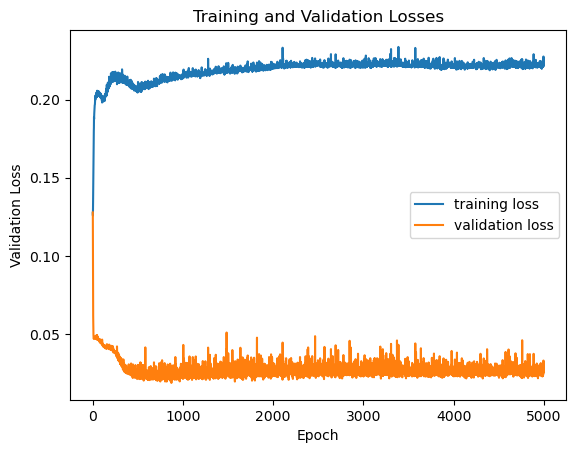

In [82]:
# plot training and validation losses over epochs

plt.plot(myNN_training_loss, label="training loss")
plt.plot(myNN_val_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()


> The validation loss spikes up and down quite often, but the fact that it is consistently decreasing is very oportune. The oscillating behavior is likely due to the stochastic gradient descent that is updating the weights one sample at a time. When all samples have been utilized, one epoch has been completed. Therefore, within one epoch, there are approximately 400 updates to the weights, and the order or permutation of the weights chosen matters. Nevertheless, the validation loss reached low values as the epochs increased. 

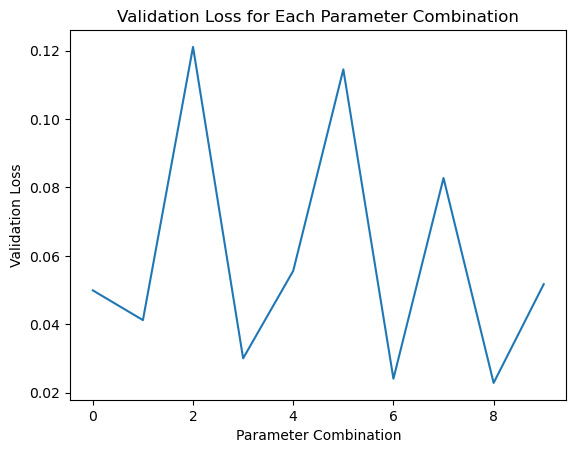

Best Parameter Combination: Epochs = 1921, Learning Rate = 0.026366508987303583


In [83]:
# Using a form of random search to tune the epoch and learning rate hyperparameters of the neural network

from sklearn.model_selection import ParameterSampler

# a list of a distribution of learning rates was already created prior, learning_rates
# a list for the a small epoch distribution of values is create  below, with 15 total values
epochs_list = np.linspace(500, 5000, 20, dtype=int).tolist()


# define the parameter grid
param_grid = {"max_epochs": epochs_list, "learning_rate": learning_rates}

# the number of iterations for the random search
n_iter = 10

# create the random parameter combinations
param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

# create a list to store the validation loss for each parameter combination
val_loss_list = []

# loop through the parameter combinations
for param_combination in param_combinations:

    # create a new neural network with the current parameter combination
    myNN_randsearch = myNeuralNetwork(
        n_in=2,
        n_layer1=5,
        n_layer2=5,
        n_out=1,
        learning_rate=param_combination["learning_rate"],
        random_state=None,
    )
    # fit the neural network to the training data
    myNN_randsearch_training_loss, myNN_randsearch_val_loss = myNN_randsearch.fit(
        X_train_2b,
        y_train_2b,
        max_epochs=param_combination["max_epochs"],
        learning_rate=param_combination["learning_rate"],
        get_validation_loss=True,
        X_val=X_val_2b,
        y_val=y_val_2b,
    )
    # append the final validation loss to the list
    val_loss_list.append(myNN_randsearch_val_loss[-1])

# plot the validation loss for each parameter combination
plt.plot(val_loss_list)
plt.xlabel("Parameter Combination")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Each Parameter Combination")
plt.show()

# find the index of the parameter combination with the lowest validation loss
best_param_index = np.argmin(val_loss_list)
# print the best parameter combination
print(
    "Best Parameter Combination: Epochs = {}, Learning Rate = {}".format(
        param_combinations[best_param_index]["max_epochs"],
        param_combinations[best_param_index]["learning_rate"],
    )
)


- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 


In [84]:
# Refitting the model to the tuned hyperparameters
myNN = myNeuralNetwork(
    n_in=2,
    n_layer1=5,
    n_layer2=5,
    n_out=1,
    learning_rate=param_combinations[best_param_index]["learning_rate"],
    random_state=None,
)
myNN.fit(
    X_train_2b,
    y_train_2b,
    max_epochs=param_combinations[best_param_index]["max_epochs"],
    learning_rate=param_combinations[best_param_index]["learning_rate"],
    get_validation_loss=False,
    X_val=X_val_2b,
    y_val=y_val_2b,
)
print("")


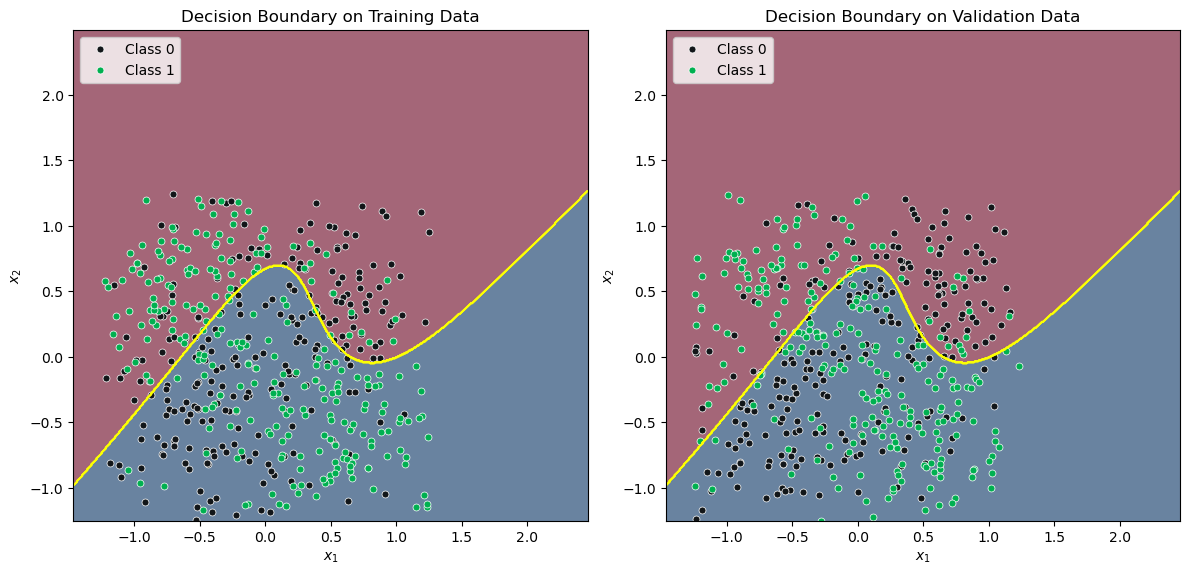

Training Accuracy:  0.955
Validation Accuracy:  0.95


In [85]:
# plotting the decision boundary of the neural network for the training and validation sets

# fig = plt.figure(figsize=(12, 12), constrained_layout=True)
fig = plt.figure(figsize=(12, 12), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

limits_2b = [
    X_train_2b.min() - 0.1,
    X_train_2b.max() + 0.1,
    X_val_2b.min() - 0.1,
    X_val_2b.max() + 0.1,
]

# plotting the data for the training set and its decision boundary
plot_data(ax1, X_train, y_train, "Decision Boundary on Training Data", limits_2b)
plot_decision_boundary(ax1, myNN, limits_2b)

# plotting the data for the validation set and its decision boundary
plot_data(ax2, X_val, y_val, "Decision Boundary on Validation Data", limits_2b)
plot_decision_boundary(ax2, myNN, limits_2b)

plt.show()

# print the accuracy scores for the training and validation sets
print("Training Accuracy: ", myNN.accuracy_score(X_train_2b, y_train_2b))
print("Validation Accuracy: ", myNN.accuracy_score(X_val_2b, y_val_2b))


- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead.*

In [86]:
# getting multiple probability scores for the ROC curves for the neural network and MLPClassifier
# breaking it into two code blocks for ease of troubleshooting

myNN_proba_all_scores = {"probabilities": np.array([]), "truth": np.array([])}
myNN_roc_components = {
    "fpr": np.array([]),
    "tpr": np.array([]),
    "thresholds": np.array([]),
}

for i in range(10):

    myNN = myNeuralNetwork(
        n_in=2,
        n_layer1=5,
        n_layer2=5,
        n_out=1,
        learning_rate=param_combinations[best_param_index]["learning_rate"],
        random_state=42,
    )

    myNN.fit(
        X_train_2b,
        y_train_2b,
        max_epochs=param_combinations[best_param_index]["max_epochs"],
        learning_rate=param_combinations[best_param_index]["learning_rate"],
        get_validation_loss=False,
        X_val=X_val_2b,
        y_val=y_val_2b,
    )

    myNN_scores = myNN.predict_proba(X_test_2b)
    myNN_scores = myNN_scores.reshape(
        -1,
    )
    myNN_proba_all_scores["probabilities"] = np.append(
        myNN_proba_all_scores["probabilities"], myNN_scores
    )
    myNN_proba_all_scores["truth"] = np.append(
        myNN_proba_all_scores["truth"], y_test_2b
    )


In [87]:
base_2b_proba_all_scores = {"probabilities": np.array([]), "truth": np.array([])}
base_2b_roc_components = {
    "fpr": np.array([]),
    "tpr": np.array([]),
    "thresholds": np.array([]),
}

for i in range(10):

    base_2b = MLPClassifier(
        learning_rate_init=param_combinations[best_param_index]["learning_rate"],
        hidden_layer_sizes=(5, 5),
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="logistic",
        n_iter_no_change=1000,
        batch_size=1,
        max_iter=param_combinations[best_param_index]["max_epochs"],
        random_state=42,
    )

    base_2b.fit(X_train_2b, y_train_2b)
    base_2b_scores = base_2b.predict_proba(X_test_2b)

    base_2b_proba_all_scores["probabilities"] = np.append(
        base_2b_proba_all_scores["probabilities"], base_2b_scores[:, 1]
    )
    base_2b_proba_all_scores["truth"] = np.append(
        base_2b_proba_all_scores["truth"], y_test_2b
    )


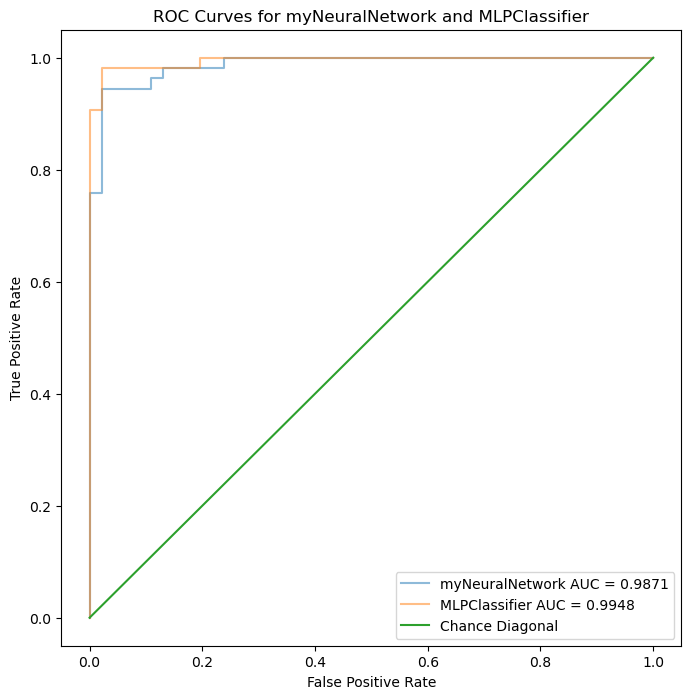

In [88]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# Calculating the auc scores for the myNeuralNetwork and the counterpart MLP classifier
myNN_fpr, myNN_tpr, myNN_thresholds = roc_curve(
    myNN_proba_all_scores["truth"], myNN_proba_all_scores["probabilities"]
)
myNN_auc = auc(myNN_fpr, myNN_tpr)

base_2b_fpr, base_2b_tpr, base_2b_thresholds = roc_curve(
    base_2b_proba_all_scores["truth"], base_2b_proba_all_scores["probabilities"]
)
base_2b_auc = auc(base_2b_fpr, base_2b_tpr)

# Plotting the ROC curves

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(myNN_fpr, myNN_tpr, label=f"myNeuralNetwork AUC = {myNN_auc:.4f}", alpha=0.5)

ax1.plot(
    base_2b_fpr, base_2b_tpr, label=f"MLPClassifier AUC = {base_2b_auc:.4f}", alpha=0.5
)

# Chance Diagonal
ax1.plot([0, 1], [0, 1], label="Chance Diagonal")
ax1.legend()
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curves for myNeuralNetwork and MLPClassifier")

plt.show()


>First of all, the myNeuralNetwork implementation was slightly outperformed by the MLPClassifier model. Besides having a higher AUC score, the MLP classifier had a true positive rate that maxed with a low false positive rate of approximately 0.3, contrasting with the slightly higher false positive rate required for the myNeuralNetwork object to max it true positive rate. It is hard to attribute an all-encompassing reason for this behavior. Both of the models' parameters were set to be as identical as possible. To eliminate the possibility of advantageous and lucky selection of random weights, identical random states were set for both models, and the true and false positive rate scores were obtained from the aggregated probabilities across 10 runs. This last implementation was applied to mitigate the possibility of the myNeuralNetwork model having a potentially luckier choice of randomly chosen samples for the stochastic gradient descent, where the update to the weights is happening one sample at a time. Regardless, the performance advantage is evident above, and this was a wonderful thought exercise

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

> The myNeuralNetwork implementation can be improved in a myriad of ways. The most immediately obvious one is adding batch size to allow for minibatch stochastic gradient descent. Instead of relying on updating the weights with one sample, one could use multiple samples, which would also imply adding a batch size argument. Another improvement is being able to scale the model for multiple layers, since the current implementation is tailored to two hidden layers. An additional improvement that comes to mind is the variety of optimizers during the gradient descent process, such as applying momentum based optimizers like "adam". In this same train of thought, another optimization is adding more activation functions such as "relu", as well as scaling the model to allow mixing and matching of different activation functions. All things considered, this model is very barebones. In short, neural networks are hard to code, hats off to sklearn. 